In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
path = r'C:\Users\weber\OneDrive\Dieter\cGaN_sim_300kV\DPs\CBED_MSAP.raw'
shape = (50, 50, 189, 189)

In [4]:
data = np.memmap(path, mode='r', shape=shape, dtype=np.float32)

In [5]:
data.shape

(50, 50, 189, 189)

In [6]:
reordered = np.moveaxis(data, (0, 1), (2, 3))

In [7]:
reordered.shape

(189, 189, 50, 50)

<IPython.core.display.Javascript object>


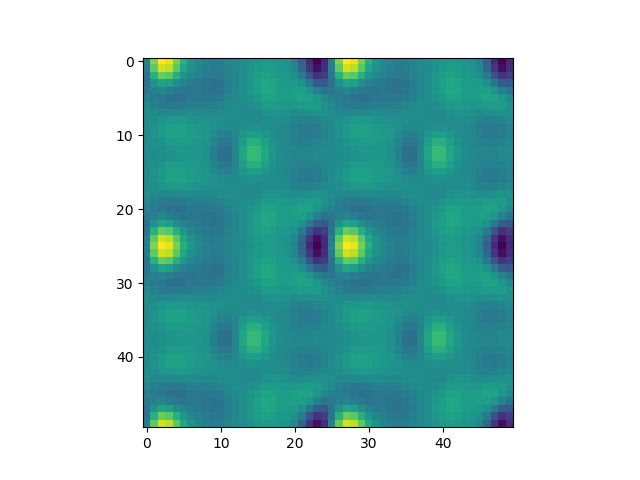

In [8]:
fig, axes = plt.subplots()
plt.imshow(reordered[50,94])

In [9]:
ffts = np.fft.fft2(reordered)

In [10]:
ffts.shape, ffts.dtype

((189, 189, 50, 50), dtype('complex128'))

<IPython.core.display.Javascript object>


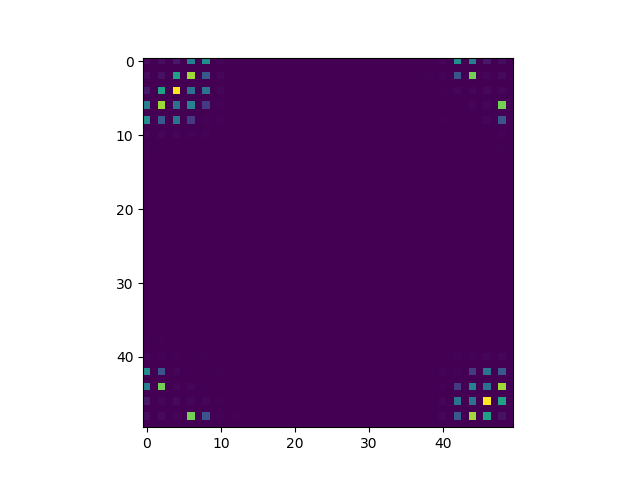

In [11]:
fig, axes = plt.subplots()
plt.imshow(np.abs(ffts[70,70] - ffts[94,94]))

In [12]:
rearranged_ffts = np.moveaxis(ffts, (2, 3), (0, 1))

In [13]:
rearranged_ffts.shape

(50, 50, 189, 189)

In [14]:
Nblock = np.array(rearranged_ffts.shape[0:2])
Nscatter = np.array(rearranged_ffts.shape[2:4])

dpix = 0.5654/50*1e-9
semiconv = 25e-3
semiconv_pix = 78.6649
lamb = 1.96e-12
d_Kf = np.sin(semiconv)/lamb/semiconv_pix
d_Qp = 1/dpix/Nblock

In [15]:
d_Qp / d_Kf

array([10.90903898, 10.90903898])

<IPython.core.display.Javascript object>


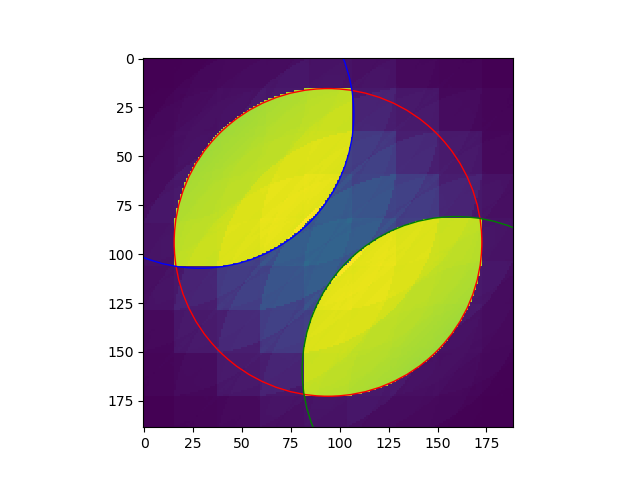

In [36]:
fig, axes = plt.subplots()

qp = np.array((6, 6))

plt.imshow(np.abs(rearranged_ffts[tuple(qp)]))

center = np.array(rearranged_ffts.shape)[-2:] // 2

axes.add_artist(plt.Circle(np.flip(center), radius=semiconv_pix, fill=False, color='r'))

flip = qp > Nblock / 2
real_qp = qp.copy()
real_qp[flip] = qp[flip] - Nblock[flip]
shift = real_qp * d_Qp / d_Kf
axes.add_artist(plt.Circle((center + shift), radius=semiconv_pix, fill=False, color='g'))
axes.add_artist(plt.Circle((center - shift), radius=semiconv_pix, fill=False, color='b'))

In [17]:
y, x = np.ogrid[0:Nscatter[0], 0:Nscatter[1]]
cy, cx = center
sy, sx = shift
filter_center = (y - cy)**2 + (x - cx)**2 < semiconv_pix**2
filter_positive = (y - cy - sy)**2 + (x - cx - sx)**2 < semiconv_pix**2
filter_negative = (y - cy + sy)**2 + (x - cx + sx)**2 < semiconv_pix**2

mask_positive = np.all((filter_center, filter_positive, np.invert(filter_negative)), axis=0)
mask_negative = np.all((filter_center, filter_negative, np.invert(filter_positive)), axis=0)

<IPython.core.display.Javascript object>


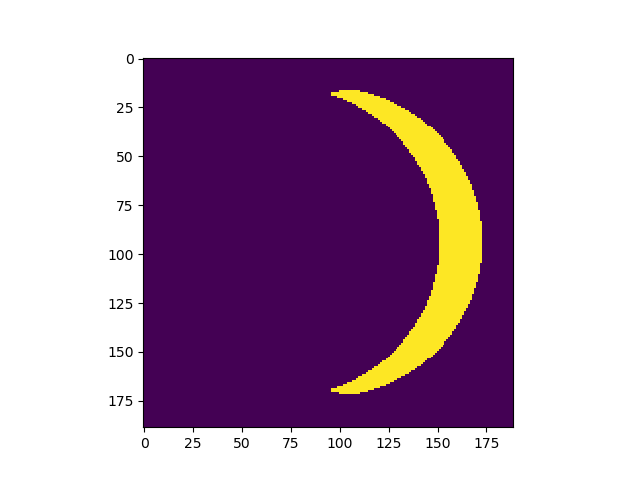

In [18]:
fig, axes = plt.subplots()

plt.imshow(mask_positive)

<IPython.core.display.Javascript object>


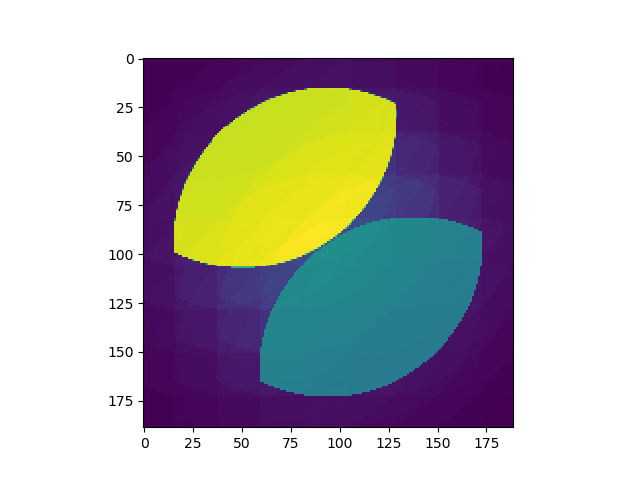

In [19]:
fig, axes = plt.subplots()

monitor = np.array((4, 6))

result_f = np.zeros(rearranged_ffts.shape[:2], dtype=rearranged_ffts.dtype)

cy, cx = np.array(rearranged_ffts.shape)[-2:] // 2

y, x = np.ogrid[0:Nscatter[0], 0:Nscatter[1]]

filter_center = (y - cy)**2 + (x - cx)**2 < semiconv_pix**2

for q in range(Nblock[0]):
    for p in range(Nblock[1]):
        qp = np.array((q, p))
        flip = qp > Nblock / 2
        real_qp = qp.copy()
        real_qp[flip] = qp[flip] - Nblock[flip]
        
        sx, sy = real_qp * d_Qp / d_Kf
        
        filter_positive = (y - cy - sy)**2 + (x - cx - sx)**2 < semiconv_pix**2
        filter_negative = (y - cy + sy)**2 + (x - cx + sx)**2 < semiconv_pix**2

        mask_positive = np.all((filter_center, filter_positive, np.invert(filter_negative)), axis=0)
        mask_negative = np.all((filter_center, filter_negative, np.invert(filter_positive)), axis=0)
        
        f = rearranged_ffts[q, p]
        
        divide = 0
        
        if np.count_nonzero(mask_positive) > 0:
            result_f[q, p] += np.average(f[mask_positive])
            divide += 1
        if np.count_nonzero(mask_negative) > 0:
            result_f[q, p] -= np.average(f[mask_negative])
            divide += 1
            
        if divide > 0:
            result_f[q, p] /= divide
            
        if np.all(qp == monitor):
            plt.imshow(np.abs(f) + mask_negative * np.max(np.abs(f)))
        
result_f[0, 0] = np.average(rearranged_ffts[0, 0, filter_center])
#             

<IPython.core.display.Javascript object>


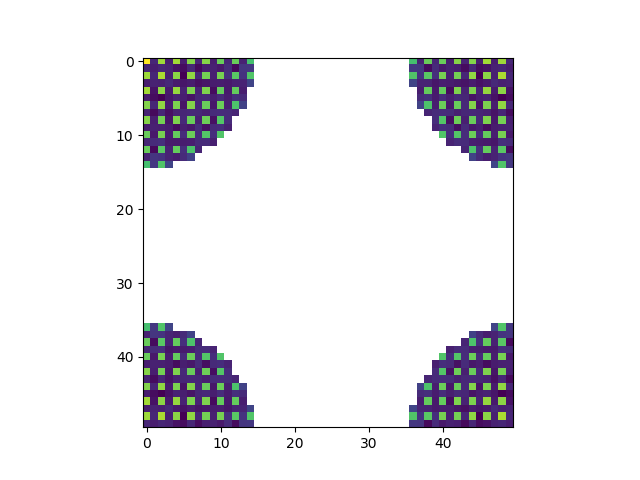

In [20]:
fig, axes = plt.subplots()

plt.imshow(np.abs(result_f), norm=LogNorm())

<IPython.core.display.Javascript object>


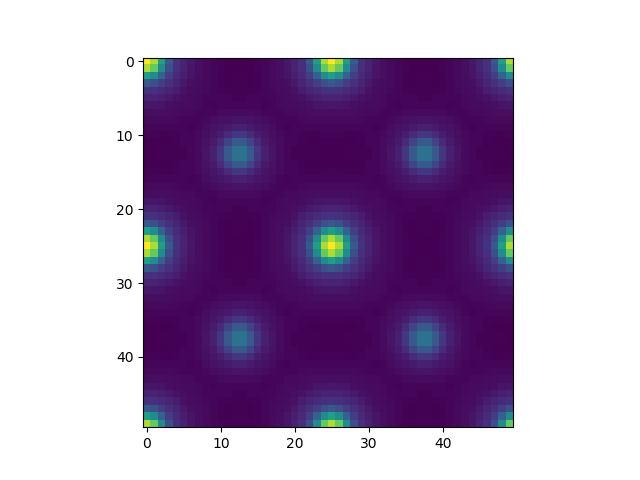

In [21]:
fig, axes = plt.subplots()

plt.imshow(np.angle(np.fft.ifft2(result_f)))